## Marketing channel classification model
마케팅 채널 A와 B를 구분할 수 있는 **채널 분류 모델**  

타겟변수가 marketing_channel로 categorical variable이고, A와 B 두 가지로 분류되는 **binary classification** 문제이다.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import datetime
from collections import Counter

In [2]:
user_info = pd.read_csv('user_info.csv')
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445220 entries, 0 to 445219
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_uuid          445220 non-null  object 
 1   marketing_channel  445220 non-null  object 
 2   sex                445220 non-null  object 
 3   age_group          436109 non-null  object 
 4   date_joined        445220 non-null  object 
 5   os                 445220 non-null  object 
 6   visits             405085 non-null  float64
 7   revenue            405085 non-null  float64
dtypes: float64(2), object(6)
memory usage: 27.2+ MB


결측치 처리를 하기 위해 우선 결측치의 패턴을 확인해야 한다.  
결측치는 세 개의 변수에 집중되어 있고, age_group의 약 2%, visits와 revenue의 9%를 차지한다.

In [3]:
user_info = user_info.drop(['user_uuid'], axis=1) #unnecessary column
user_info.isnull().sum()
user_info.isnull().sum() / len(user_info) #explore missing data

marketing_channel    0.000000
sex                  0.000000
age_group            0.020464
date_joined          0.000000
os                   0.000000
visits               0.090146
revenue              0.090146
dtype: float64

결측치를 시각화해보면 age_group의 결측치는 완전 무작위 결측으로 보이고, visits와 revenue의 결측치는 서로 연관되어 있지만 비관측된 다른 변수들과는 무관한 무작위 결측으로 판단된다.

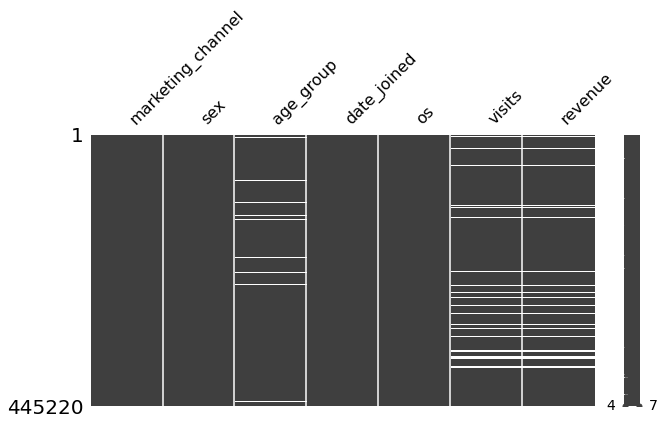

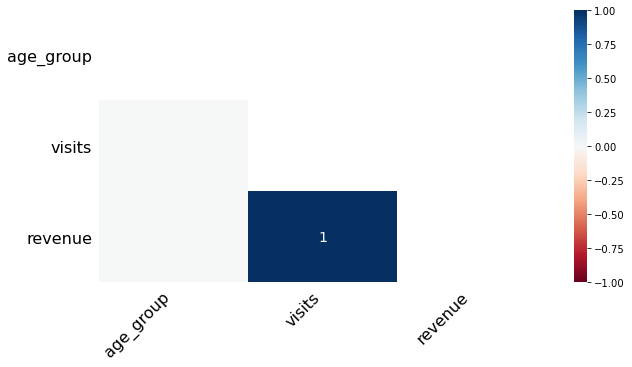

In [4]:
msno.matrix(user_info, figsize=(10, 5))
msno.heatmap(user_info, figsize=(10, 5))
plt.show()

age_group의 결측치는 완전 무작위 결측이며 2%로 매우 적으므로 제거한다.  
visits와 revenue의 결측치는 의미상으로 '회원가입 후 한번도 방문하지 않고 매출이 발생하지 않은 사용자'를 뜻하므로, 0으로 대체하는 것이 합리적이다.

In [5]:
user_info.dropna(subset=['age_group'], axis=0, inplace=True)
user_info.fillna({'visits':0, 'revenue':0}, inplace=True)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436109 entries, 0 to 445219
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketing_channel  436109 non-null  object 
 1   sex                436109 non-null  object 
 2   age_group          436109 non-null  object 
 3   date_joined        436109 non-null  object 
 4   os                 436109 non-null  object 
 5   visits             436109 non-null  float64
 6   revenue            436109 non-null  float64
dtypes: float64(2), object(5)
memory usage: 26.6+ MB


다음으로, 이상치를 판단하는데 가입기간을 고려하기 위해 새로운 column을 만들었다.  
period column은 date_joined를 기준으로 데이터 추출 시점까지의 기간(일)으로 정의한다.

In [6]:
data_extraction_date = datetime.datetime(2030, 12, 31)
user_info['period'] = user_info['date_joined'].apply(lambda x: (data_extraction_date - pd.to_datetime(x)).days)

Numerical features 중에 이상치를 제거하기 위해 IQR rule을 사용하였다.  
단순히 IQR rule을 사용해서 이상치로 분류되는 데이터를 모두 제거하기보다, 해당 feature의 대표 통계량과 boxplot을 종합적으로 판단하여 이상치를 처리하였다.

In [7]:
def detect_outlier(df, n, features):
  outlier_indices = []
  for col in features:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    outlier_range = 1.5 * IQR
    outlier_col = df[(df[col] < Q1 - outlier_range) | (df[col] > Q3 + outlier_range)].index
    outlier_indices.extend(outlier_col)
  outlier_indices = Counter(outlier_indices)
  outliers = list(k for k, v in outlier_indices.items() if v >= n)
  return outliers

먼저 visits의 경우는 평균이 9.2이고 표준편차가 9.6이므로 대략 0 ~ 19 사이에 68%의 데이터가 존재한다.  
가입한 사용자 중 앱을 한번도 방문하지 않은 경우는 충분히 존재할 수 있으므로, 방문 수가 극단적으로 많은 경우만 이상치로 간주하는 것이 합리적이다.  
계산된 이상치의 수는 19,170개인데, 이들 중 일부를 살펴보았을 때 정상적인 값으로 판단되는 데이터가 다수 존재한다.  
예를 들어, period가 200일 이상으로 충분히 긴 경우라면 30회 이상의 방문 수가 발생할 가능성이 있으므로 이상치로 보기 어렵다.

count    436109.000000
mean          9.224020
std           9.558176
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max         172.000000
Name: visits, dtype: float64


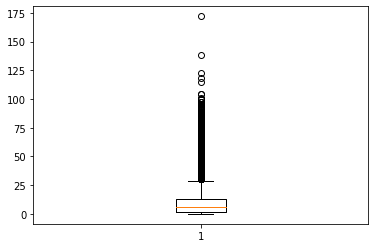

num. of outliers in visits:  19170
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
19         channel_A  female     20-29  2030-05-10  android    32.0    135.0   
20         channel_A  female     30-39  2030-05-02  android    42.0    222.0   
37         channel_A    male     30-39  2030-05-12  android    31.0    329.0   
67         channel_A  female     30-39  2030-05-21  android    46.0     80.0   
91         channel_A  female     20-29  2030-05-12      iOS    30.0     40.0   

    period  
19     235  
20     243  
37     233  
67     224  
91     233  


In [8]:
print(user_info['visits'].describe())
plt.boxplot(user_info['visits'])
plt.show()

outlier_visits_calc = detect_outlier(user_info, 1, ['visits'])
print('num. of outliers in visits: ', len(outlier_visits_calc))
print(user_info.loc[outlier_visits_calc].head())

위의 계산된 이상치들 중 초반 데이터(visits이 30 ~ 40 이고 period가 220 ~ 240)들은 period-visits scatter plot에서는 전혀 이상치로 보이지 않는다.   
scatter plot에서 period와 관계없이 visits이 0인 경우는 충분히 발생할 수 있으므로 이상치로 처리하지 않는다.  
그러나 period가 짧은데 visits이 극단적으로 많이 나온 경우는 이상치로 볼 수 있으므로, 해당 데이터는 제거해준다.  

(436108, 8)

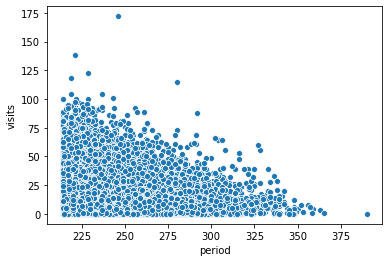

In [9]:
sns.scatterplot(x='period', y='visits', data=user_info)
outlier_visits_drop = user_info[(user_info['period'] < 300) & (user_info['visits'] > 170)].index
user_info = user_info.drop(outlier_visits_drop, axis=0)
user_info.shape

revenue의 경우는 평균이 170.7이고 표준편차가 167.6이므로 대략 3 ~ 340 사이에 68%의 데이터가 존재한다.  
마찬가지로 앱을 한번도 방문하지 않은 사용자는 revenue도 0일 것이므로, revenue가 극단적으로 큰 경우만 이상치로 고려하였다.  
계산된 이상치의 수는 23,939개이다.

count    436108.000000
mean        170.713825
std         167.627040
min           0.000000
25%          67.000000
50%         129.000000
75%         223.000000
max        4623.000000
Name: revenue, dtype: float64


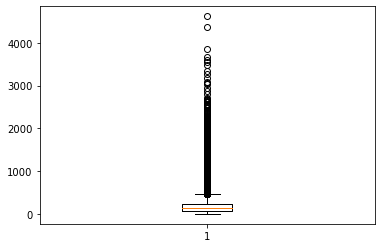

num. of outliers in revenue:  23939
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
5          channel_A  female     40-49  2030-04-24  android     1.0    906.0   
9          channel_B  female     50-59  2030-05-13  android     4.0    825.0   
12         channel_A  female     30-39  2030-05-12  android     8.0    517.0   
27         channel_A    male     50-59  2030-05-30      iOS     2.0    479.0   
42         channel_A  female     30-39  2030-05-29      iOS     6.0    680.0   

    period  
5      251  
9      232  
12     233  
27     215  
42     216  


In [10]:
print(user_info['revenue'].describe())
plt.boxplot(user_info['revenue'])
plt.show()

outlier_revenue_calc = detect_outlier(user_info, 1, ['revenue'])
print('num. of outliers in revenue: ', len(outlier_revenue_calc))
print(user_info.loc[outlier_revenue_calc].head())

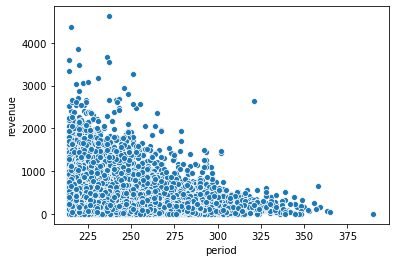

In [11]:
sns.scatterplot(x='period', y='revenue', data=user_info)

대신 basket size를 구하여 visits 대비 revenue가 극단적으로 큰 데이터를 이상치로 판단하였다.  
user_info에 basket_size column을 추가하여 boxplot을 그려 2000 이상인 이상치를 제거하였다.

count    436108.000000
mean         42.341820
std          77.638738
min           0.000000
25%           6.461538
50%          17.333328
75%          44.749989
max        4622.995377
Name: basket_size, dtype: float64


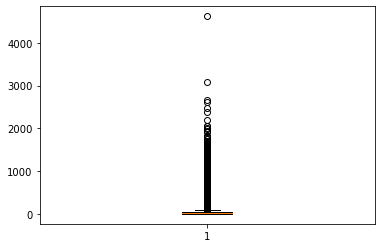

num. of outliers in basket_size:  45036
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
5          channel_A  female     40-49  2030-04-24  android     1.0    906.0   
9          channel_B  female     50-59  2030-05-13  android     4.0    825.0   
17         channel_A    male     30-39  2030-04-15  android     1.0    108.0   
27         channel_A    male     50-59  2030-05-30      iOS     2.0    479.0   
34         channel_B    male       -99  2030-05-25  android     2.0    268.0   

    period  basket_size  
5      251   905.999094  
9      232   206.249948  
17     260   107.999892  
27     215   239.499880  
34     220   133.999933  


In [12]:
def rev_per_vis(x):
  return x['revenue']/(x['visits'] + 0.000001)

user_info['basket_size'] = user_info.apply(rev_per_vis, axis=1)
print(user_info['basket_size'].describe())
plt.boxplot(user_info['basket_size'])
plt.show()

outlier_basket_size_calc = detect_outlier(user_info, 1, ['basket_size'])
print('num. of outliers in basket_size: ', len(outlier_basket_size_calc))
print(user_info.loc[outlier_basket_size_calc].head())

(436098, 9)


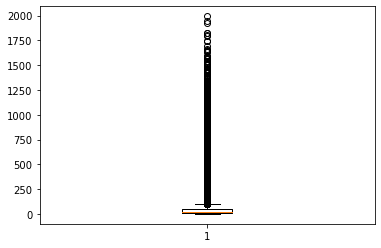

In [13]:
outlier_basket_size_drop = user_info[(user_info['basket_size'] > 2000)].index
user_info = user_info.drop(outlier_basket_size_drop, axis=0)
print(user_info.shape)
plt.boxplot(user_info['basket_size'])
plt.show()

In [14]:
user_info.to_csv('user_info_preprocessed.csv', index=False)

In [15]:
user_info = pd.read_csv('user_info_preprocessed.csv')
user_info = user_info.drop(['date_joined'], axis=1) #used as period
user_info.head()

,marketing_channel,sex,age_group,os,visits,revenue,period,basket_size
0,channel_A,male,30-39,android,23.0,304.0,235,13.217391
1,channel_B,male,20-29,android,5.0,195.0,235,38.999992
2,channel_A,male,30-39,android,1.0,78.0,220,77.999922
3,channel_A,female,30-39,iOS,18.0,202.0,225,11.222222
4,channel_A,male,30-39,android,9.0,197.0,225,21.888886


설명변수별 타겟변수와의 관계를 시각화해보면, 타겟변수를 두 그룹으로 분류할 가능성이 높은 설명변수가 두드러지게 나타나지 않는다.  
즉, 모든 변수들에 대해 Channel A와 B라는 라벨이 고르게 분포한다.

(436098, 7) (436098,)


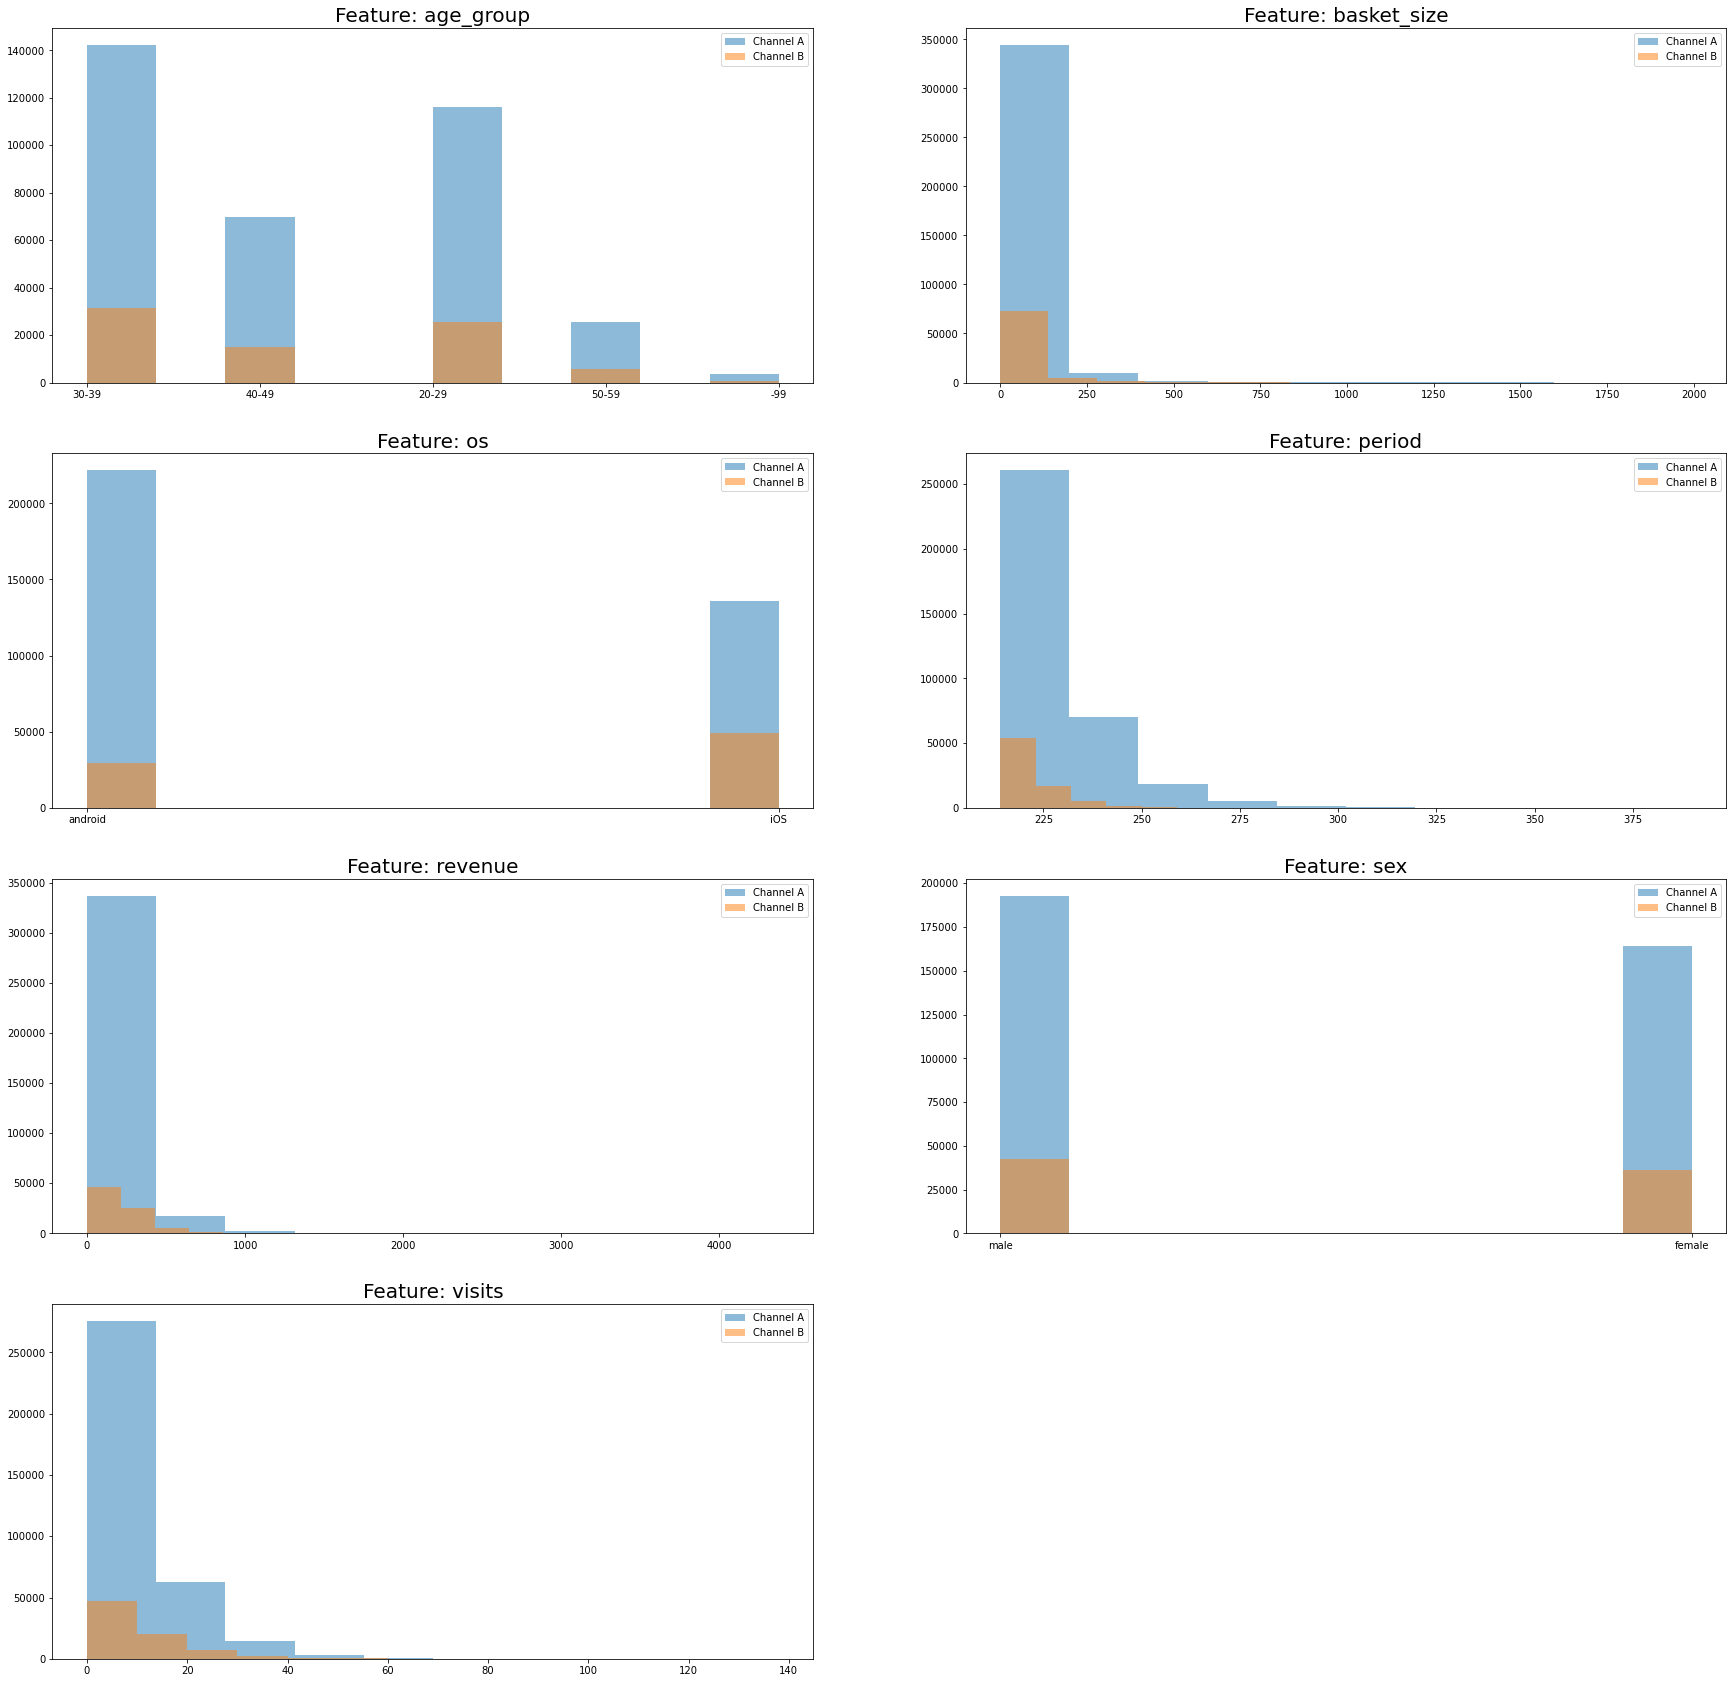

In [16]:
x = user_info[user_info.columns.difference(['marketing_channel'])]
feature_name = x.columns
y = user_info['marketing_channel']
print(x.shape, y.shape)

plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    plt.subplot(4, 2, col_idx + 1)
    plt.hist(user_info[user_info['marketing_channel'] == 'channel_A'][feature_name[col_idx]], label='Channel A', alpha=0.5)
    plt.hist(user_info[user_info['marketing_channel'] == 'channel_B'][feature_name[col_idx]], label='Channel B', alpha=0.5)
    plt.legend()
    plt.title("Feature: " + feature_name[col_idx], fontsize=20)
plt.show()

In [17]:
num_feats = x.dtypes[x.dtypes != 'object'].index
cat_feats = x.dtypes[x.dtypes == 'object'].index

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x[num_feats]) #data scaling numerical features

In [19]:
for cat in list(cat_feats):
    print(x[cat].value_counts())
    print('-'*50)
x_dummy = pd.get_dummies(x, columns=cat_feats) #convert categorical features into dummy variables
x_rev = np.concatenate((x_scaled, x_dummy), axis=1) #merge with scaled numerical features
print(x_rev.shape)

30-39    173709
20-29    141862
40-49     84775
50-59     31224
-99        4528
Name: age_group, dtype: int64
--------------------------------------------------
android    251473
iOS        184625
Name: os, dtype: int64
--------------------------------------------------
male      235477
female    200621
Name: sex, dtype: int64
--------------------------------------------------
(436098, 17)


In [20]:
y_a = (y == 'channel_A')
y_a.value_counts(normalize=True) #convert target as boolean (channel_A == 1)

True     0.819325
False    0.180675
Name: marketing_channel, dtype: float64

Channel A와 B가 비대칭하게 분포하는 데이터셋이므로, 타겟값의 분포가 training set과 test set에 비슷한 비율로 추출되었는지 확인해야한다.

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_rev, y_a, test_size = 0.2, random_state = 1)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

True     0.819014
False    0.180986
Name: marketing_channel, dtype: float64
True     0.820569
False    0.179431
Name: marketing_channel, dtype: float64


여러 분류 모델의 성능을 비교하여 적절한 모델을 선택한다.  
이 과정에서 cross validation을 사용하는데, 클래스가 비대칭한 데이터셋이므로 층화추출(stratified)을 쓴다.

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold 

skfold = StratifiedKFold(n_splits=3, shuffle = True, random_state=42) 

def display_scores(model_name, score):
    print('Model: ', model_name)
    print('Scores: ', score)
    print('Mean score: ', score.mean())

In [23]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=1)
sgd.fit(x_train, y_train)
score_sgd = cross_val_score(sgd, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('SGD classifier', score_sgd)

Model:  SGD classifier
Scores:  [0.8188713  0.81900888 0.81901593]
Mean score:  0.8189653691277647


In [24]:
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC(criterion='entropy')
tree.fit(x_train, y_train)
score_tree = cross_val_score(tree, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('Decision tree', score_tree)

Model:  Decision tree
Scores:  [0.74150637 0.74172994 0.74106559]
Mean score:  0.741433967265423


In [25]:
from sklearn.ensemble import RandomForestClassifier as RFC
forest = RFC(criterion='gini', n_estimators=350, n_jobs=4)
forest.fit(x_train, y_train)
score_forest = cross_val_score(forest, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('Random forest', score_forest)

Model:  Random forest
Scores:  [0.79660857 0.79767484 0.79644344]
Mean score:  0.7969089467793576


In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
score_knn = cross_val_score(knn, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('KNN', score_knn)

Model:  KNN
Scores:  [0.79351294 0.79368492 0.79349396]
Mean score:  0.7935639390561297


In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, random_state=1)
xgb.fit(x_train, y_train)
score_xgb = cross_val_score(xgb, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('XGBoost', score_xgb)

C:\Users\CSD\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSD\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XGBoost
Scores:  [0.81624861 0.81695373 0.81638462]
Mean score:  0.81652898679662


In [28]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=500, random_state=1)
lgbm.fit(x_train, y_train)
score_lgbm = cross_val_score(lgbm, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('LightGBM', score_lgbm)

Model:  LightGBM
Scores:  [0.81986018 0.82025573 0.81865477]
Mean score:  0.8195902265678519


위 모델들 중에 정확도가 가장 높은 LightGBM 모델을 선택하여, hyperparameter tuning을 하였다.

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

분류모델이므로 성능 지표로 confusion matrix의 accuracy, precision, recall, f1, roc-auc 를 사용한다.

In [ ]:
#before tuning
tic = time.time()

lgbm_before = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                             objective= 'binary', seed=27)
lgbm_before.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = lgbm_before.predict(x_val)
y_pred_proba = lgbm_before.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

Accuracy: 0.8196, Precision: 0.8266, Recall: 0.9863, F1: 0.8994  
ROC AUC: 0.7663  
time elapsed: 1.1310973167419434

max_depth, num_leaves, min_child_samples 순으로 hyperparameter tuning을 진행한다.

In [ ]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                     objective= 'binary', seed=27)
param_1 = {'max_depth':range(10,31)}
gridcv = GridSearchCV(lgbm, param_grid=param_1, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

{'max_depth': 12}  
Accuracy: 0.8197, Precision: 0.8268, Recall: 0.9860, F1: 0.8994  
ROC AUC: 0.7664  
time elapsed: 87.32647395133972

In [ ]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                      max_depth=12,
                      objective= 'binary', seed=27)
param_2 = {'num_leaves':range(10,31)}
gridcv = GridSearchCV(lgbm, param_grid=param_2, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

{'num_leaves': 11}  
Accuracy: 0.8194, Precision: 0.8283, Recall: 0.9829, F1: 0.8990  
ROC AUC: 0.7665  
time elapsed: 93.7662148475647

In [ ]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                      max_depth=12, num_leaves=11,
                      objective= 'binary', seed=27)
param_3 = {'min_child_samples':range(10,110,10)}
gridcv = GridSearchCV(lgbm, param_grid=param_3, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

{'min_child_samples': 30}  
Accuracy: 0.8195, Precision: 0.8283, Recall: 0.9830, F1: 0.8991  
ROC AUC: 0.7665  
time elapsed: 51.144272565841675

최적의 hyperparameter로 설정한 모델을 학습시켜 test set에 대해 최종 성능을 평가한다.

In [35]:
#after tuning 
lgbm_after = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                            max_depth=12, num_leaves=11,
                            min_child_samples=30,
                            objective= 'binary', seed=27)
lgbm_after.fit(x_train, y_train)

#final test
y_pred = lgbm_after.predict(x_test)
y_pred_proba = lgbm_after.predict_proba(x_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
lgbm_roc_score = roc_auc_score(y_test, y_pred_proba, average='macro')

print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

Accuracy: 0.8227, Precision: 0.8319, Recall: 0.9824, F1: 0.9009
ROC AUC: 0.7599
